# A pair of Goodwin oscillators

Trying this instead of the thalamic model so that debugging isn't so goddamn slow.

# Imports

In [130]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp

import gw2

#from generate_figures import bif1d

import importlib
import lib

import lib.util
import lib.rhs

importlib.reload(sys.modules['lib.util'])
importlib.reload(sys.modules['lib.rhs'])
from lib.util import (get_phase, freq_est, get_tongue_1d,
                      pl_exist_1d)
from lib.rhs import (rhs_avg_2d, _redu_moving, 
                     _redu_moving_avg, rhs_avg_1d, rhs_avg_1dc)


from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

reload(gw2)
reload(nm)
reload(rp)

nmc = nm.nmCoupling
rsp = rp.Response

# Dicts

In [110]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [111]:
pd1 = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
           'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
           'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
           'n':6,'L':0,'eps':0,'om':1,'om_fix':1}

In [112]:
kws1 = {'var_names':['x','y','z','v'],
        'pardict':pd1,
        'rhs':gw2.rhs,
        'coupling':gw2.coupling,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':2000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':False,
        'i_bad_dx':[False,True,False,False],
        'max_iter':20,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False}

# Defs

In [16]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [17]:
def bif1d(a,eps,del1):
    """
    for coupling only
    """

    y = rhs_avg_1dc(0,x_temp,a,eps,del1)

    #fig,axs = plt.subplots()
    #axs.plot(y)
    #plt.show()
    #plt.close()
    
    # get all zeros
    z1 = x_temp[1:][(y[1:]>0)*(y[:-1]<=0)]
    z2 = x_temp[1:][(y[1:]<0)*(y[:-1]>=0)]

    return z1,z2

In [18]:
def _full(t,y,a,eps,del1):
    pd1 = a.system1.pardict;pd2 = a.system2.pardict
    y1 = y[:4];y2 = y[4:]
    out1 = gw2.rhs(t,y1,pd1,'val',0) + eps*(del1 + gw2.coupling(y,pd1,'val',0))
    out2 = gw2.rhs(t,y2,pd2,'val',1) + eps*gw2.coupling(list(y2)+list(y1),pd2,'val',1)
    return np.array(list(out1)+list(out2))

In [203]:
def _redu(t,y,a,eps,del1):
    n = a._n[1];m = a._m[1]
    system1 = a.system1; system2 = a.system2
    h = 0
    for i in range(system1.miter):
        h += eps**(i+1)*(4*del1*np.mean(system1.z['dat'][i]) + system1.h['lam'][i](y) - system2.h['lam'][i](y))
    return h*n

In [204]:
# def _redu2(t,y,a,eps,del1):
#     n = a._n[1];m = a._m[1]
#     system1 = a.system1; system2 = a.system2
#     h = 0
#     for i in range(system1.miter):
#         h += eps**(i+1)*(4*del1*np.mean(system1.z['dat'][i]) + system1.h['lam'][i](y) - system2.h['lam'][i](y))
#     return h*n/m

In [21]:
def add_diagram(axs,a,del1,eps_list):
    zu_list = []
    zs_list = []

    zu = []
    zs = []

    for eps in eps_list:
        z1,z2 = bif1d(a,eps,del1)

        zu.append(np.mod(z1,2*np.pi))
        zs.append(np.mod(z2,2*np.pi))

    for xe, ye in zip(eps_list, zu):
        axs.scatter([xe] * len(ye), ye,s=2,c='red')

    for xe, ye in zip(eps_list, zs):
        axs.scatter([xe] * len(ye), ye,s=2,c='k')

    axs.set_ylim(-.1,2*np.pi+.1)
    axs.set_xlim(eps_list[0],eps_list[-1])
    

# Initialize

In [113]:
system1 = rsp(idx=0,model_name='gw0',**kws1)
system2 = rsp(idx=1,model_name='gw1',**kws1)

* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975461394
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975461394
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# 1:1

In [23]:
a11 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',1),
                    NP=500,
                    NH=500,
                    save_fig=True)

* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
h_data_gw0 []
* Loading H gw0, order=0...
h_data_gw1 []
* Loading H gw1, order=0...
h_data_gw0 []
* Loading H gw0, order=1...
h_data_gw1 []
* Loading H gw1, order=1...
h_data_gw0 []
* Loading H gw0, order=2...
h_data_gw1 []
* Loading H gw1, order=2...


In [24]:
eps11 = .3
del11 = -0.02
th_init11 = 3

## phase plane

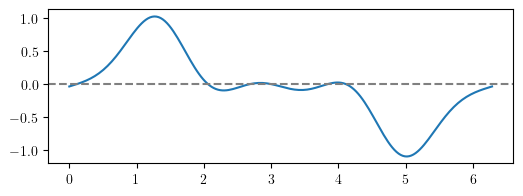

In [25]:
x_temp2 = np.linspace(0,2*np.pi,200)

rhs = _redu(0,x_temp2,a11,eps11,del11)

fig,axs = plt.subplots(figsize=(6,2))
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

## Integrate

In [26]:
dt = .01;T=200
t11 = np.arange(0,T,dt)
args11 = {'args':(a11,eps11,del11),'t_eval':t11,**kw_sim}

In [27]:
y0a = a11.system1.lc['dat'][int((th_init11/(2*np.pi))*a11.system1.TN),:]
y0b = a11.system2.lc['dat'][int((0/(2*np.pi))*a11.system2.TN),:]

y0 = np.array([y0a,y0b]).flatten()

solf11 = solve_ivp(_full,[0,t11[-1]],y0,**args11)

In [28]:
solr11 = solve_ivp(_redu,[0,t11[-1]],[th_init11],**args11)

(-200.01, 199.99)

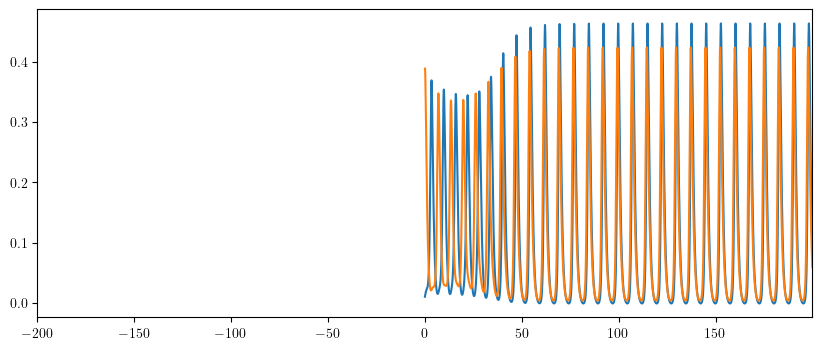

In [29]:
fig,axs = plt.subplots(figsize=(10,4))
axs.plot(solf11.t,solf11.y.T[:,0])
axs.plot(solf11.t,solf11.y.T[:,4])
#axs.set_xlim(sol_full.t[-1]-200,sol_full.t[-1])
axs.set_xlim(t11[-1]-400,t11[-1])

In [30]:
tp11a, phase11a = get_phase(t11,solf11.y.T[:,:4],skipn=20,system1=a11.system1)
tp11b, phase11b = get_phase(t11,solf11.y.T[:,4:],skipn=20,system1=a11.system2)

## Full vs phase

(0.0, 6.283185307179586)

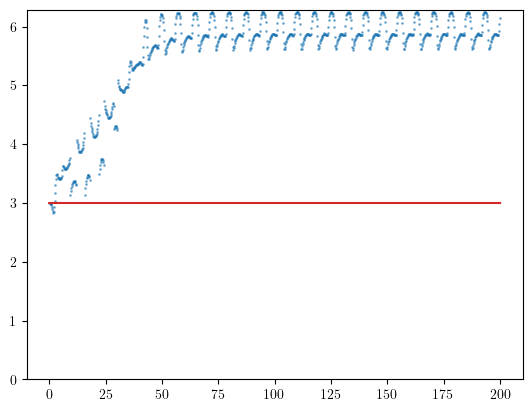

In [31]:
fig,axs = plt.subplots()
y = np.mod(phase11a - a11.om*phase11b,2*np.pi)
axs.scatter(tp11a,y,s=1,alpha=.5)
axs.plot(t11,np.mod(solr11.y.T,2*np.pi),color='tab:red')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)
axs.set_ylim(0,2*np.pi)

## Bifurcations

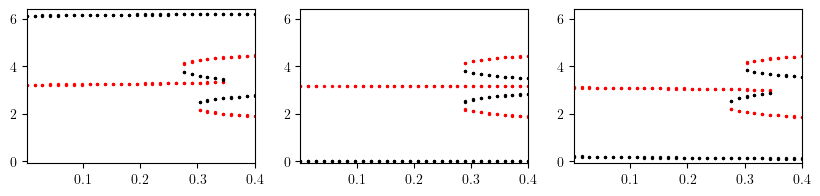

In [32]:
fig,axs=plt.subplots(1,3,figsize=(10,2))

del_list11 = np.linspace(-.02,.02,len(axs))
eps_list11 = np.linspace(.001,.4,30)

for k in range(len(del_list11)):
    add_diagram(axs[k],a11,del_list11[k],eps_list11)

# 1:2

In [114]:
a12 = nm.nmCoupling(system1,system2,
                    #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=['h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',1),_m=('om1',2),
                    NP=700,
                    NH=700,
                    save_fig=True)

* Loading p symbolic...
* Loading p symbolic...
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
h_data_gw0 []
* Loading H gw0, order=0...
h_data_gw1 []
* Loading H gw1, order=0...
h_data_gw0 []
* Loading H gw0, order=1...
h_data_gw1 []
* Loading H gw1, order=1...
h_data_gw0 []
* Loading H gw0, order=2...
h_data_gw1 []
* Loading H gw1, order=2...
h_data_gw0 []
* Computing H gw0, order=3...
h_data_gw1 []
* Computing H gw1, order=3...


In [148]:
eps12 = .08
del12 = 0.0
th_init12 = 1.75

First order starts losing accuracy around eps = 0.025 as eps increases (the reduced model reaches the same fixed point as the full model). Even at eps=0.02, the reduced and full models don't coincide in transients despite the long-term convergence.

Using order eps^2 at eps = 0.025 results in WORSE performance... So clearly if not p then there is something wrong with calculating h functions...

## Phase plane

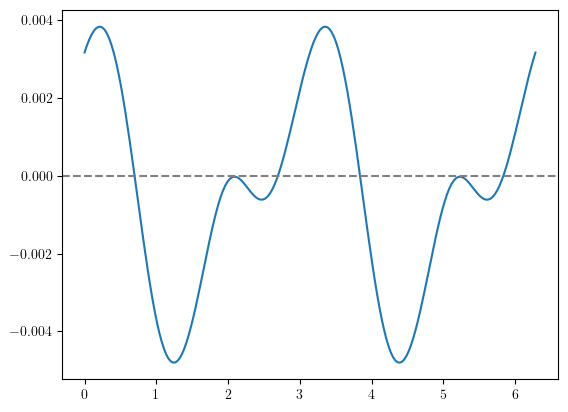

In [205]:
x_temp2 = np.linspace(0,2*np.pi,200)

# def _redu(t,y,a,eps,del1):
#     n = a._n[1];m = a._m[1]
#     system1 = a.system1; system2 = a.system2
#     h = 0
#     for i in range(system1.miter):
#         h += eps**(i+1)*(4*del1*np.mean(system1.z['dat'][i]) + system1.h['lam'][i](-y+np.pi/4) - system2.h['lam'][i](-y+np.pi/4))
#     return h*n/m

rhs = _redu(0,x_temp2,a12,eps12,del12)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

## Integrate

In [318]:
dt = .01;T=5000
t12 = np.arange(0,T,dt)
args12 = {'args':(a12,eps12,del12),'t_eval':t12,**kw_sim}

In [319]:
y0a = a12.system1.lc['dat'][int((th_init12/(2*np.pi))*a12.system1.TN),:]
y0b = a12.system2.lc['dat'][int((0/(2*np.pi))*a12.system2.TN),:]

y0 = np.array([y0a,y0b]).flatten()

solf12 = solve_ivp(_full,[0,t12[-1]],y0,**args12)

In [246]:
solr12 = solve_ivp(_redu,[0,t12[-1]],[th_init12],**args12)

(4799.99, 4999.99)

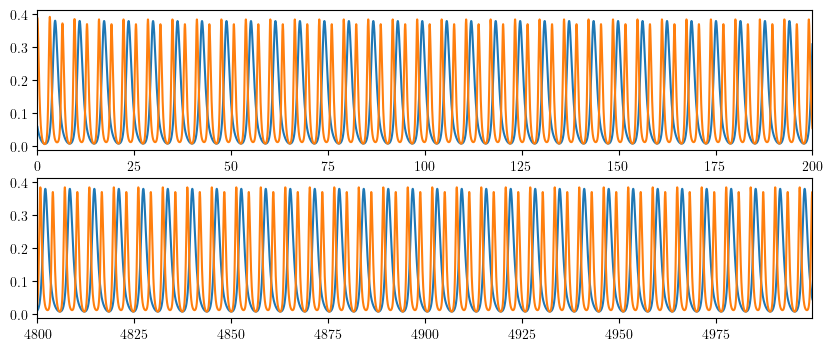

In [242]:
fig,axs = plt.subplots(2,1,figsize=(10,4))
axs[0].plot(solf12.t,solf12.y.T[:,0])
axs[0].plot(solf12.t,solf12.y.T[:,4])

axs[1].plot(solf12.t,solf12.y.T[:,0])
axs[1].plot(solf12.t,solf12.y.T[:,4])

axs[0].set_xlim(0,200)
axs[1].set_xlim(t12[-1]-200,t12[-1])

In [332]:
tp12a, phase12a = get_phase(t12,solf12.y.T[:,:4],skipn=50,system1=a12.system1)
tp12b, phase12b = get_phase(t12,solf12.y.T[:,4:],skipn=50,system1=a12.system2)

## Full vs phase

(0.0, 6.283185307179586)

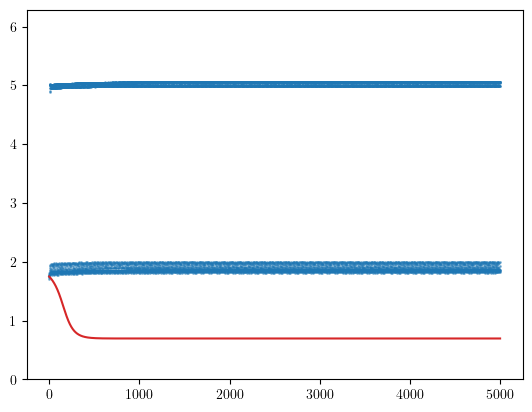

In [333]:
fig,axs = plt.subplots()
y = np.mod(phase12a - a12.om*phase12b,2*np.pi)
axs.scatter(tp12a,y,s=1,alpha=.5)
axs.plot(t12,np.mod(solr12.y.T,2*np.pi),color='tab:red')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)
axs.set_ylim(0,2*np.pi)

### Multiple Initial Conditions

In [321]:
init_phases12 = np.linspace(0,2*np.pi,10,endpoint=False)
dt = .01;T=1000
t12b = np.arange(0,T,dt)

y0b = a12.system2.lc['dat'][int((0/(2*np.pi))*a12.system2.TN),:]

full_1 = []
full_2 = []

args12b = {'args':(a12,eps12,del12),'t_eval':t12b,**kw_sim}

for i in range(len(init_phases12)):
    y0a = a12.system1.lc['dat'][int((init_phases12[i]/(2*np.pi))*a12.system1.TN),:]
    y0 = np.array([y0a,y0b]).flatten()

    solf12i = solve_ivp(_full,[0,t12b[-1]],y0,**args12b)
    tp12a, phase12ai = get_phase(t12b,solf12i.y.T[:,:4],skipn=50,system1=a12.system1)
    tp12b, phase12bi = get_phase(t12b,solf12i.y.T[:,4:],skipn=50,system1=a12.system2)

    full_1.append([tp12a,phase12ai])
    full_2.append([tp12b,phase12bi])

In [352]:
redu_1 = []

for i in range(len(init_phases12)):
    solr12i = solve_ivp(_redu,[0,t12b[-1]],[init_phases12[i]],**args12b)
    redu_1.append(solr12i)

(0.0, 6.283185307179586)

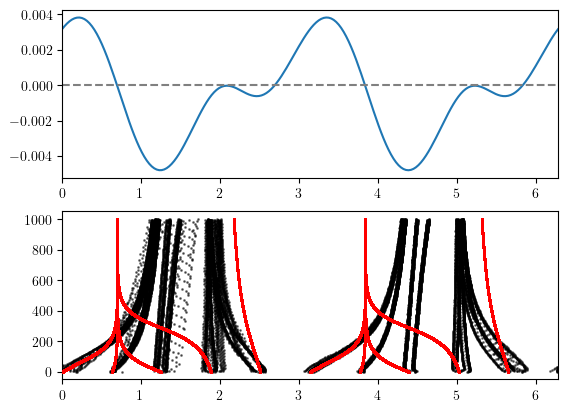

In [323]:
fig,axs = plt.subplots(2,1)
axs[0].plot(x_temp2,rhs)
axs[0].axhline(0,0,2*np.pi,ls='--',color='gray')

for i in range(len(init_phases12)):
    y = np.mod(full_1[i][1] - a12.om*full_2[i][1],2*np.pi)
    axs[1].scatter(y,full_1[i][0],s=1,alpha=.5,color='k')
    axs[1].scatter(np.mod(redu_1[i].y[0],2*np.pi),redu_1[i].t,color='r',s=1,zorder=10)
    
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)

## Bifurcations

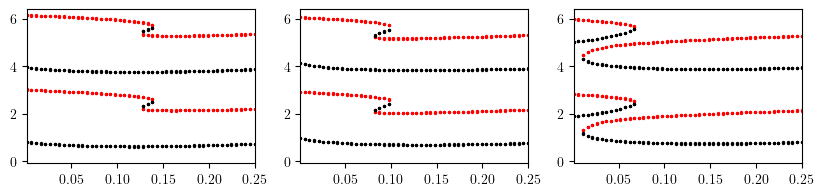

In [126]:
fig,axs=plt.subplots(1,3,figsize=(10,2))

del_list12 = np.linspace(-.002,.002,3)
eps_list12 = np.linspace(0.001,.25,50)

for k in range(len(del_list12)):
    add_diagram(axs[k],a12,del_list12[k],eps_list12)

## Unaveraged

Compare simulations between full and reduced using non-averaged, original phase-isostable coordinates.

### Z,I functions lambdified

The psi/theta equations aren't implemented in the coupling case, so I'll do it here first.

I can't use `system1.K['sym']` or `system1.G['sym']` because they are both in terms of epsilon. I need to fall back to `system1.z['vec_psi']` and use `system1.z_og` to define a substitution rule. `a12.z_og` contains indexed variables used to define the $\psi$ expansion. 

`system1.z_og` is in the order: `zx0[0], zx0[1], zy0[0], zy0[1]`, i.e., variable 1, all orders, then next variable all orders, etc.

In [133]:
print(a12.system1.z_og)

[zx0[0], zx0[1], zx0[2], zx0[3], zy0[0], zy0[1], zy0[2], zy0[3], zz0[0], zz0[1], zz0[2], zz0[3], zv0[0], zv0[1], zv0[2], zv0[3]]


In [134]:
print(a12.system1.i['vec_psi'])
print(a12.system1.z['vec_psi'])

Matrix([[psi**3*ix0[3] + psi**2*ix0[2] + psi*ix0[1] + ix0[0]], [psi**3*iy0[3] + psi**2*iy0[2] + psi*iy0[1] + iy0[0]], [psi**3*iz0[3] + psi**2*iz0[2] + psi*iz0[1] + iz0[0]], [psi**3*iv0[3] + psi**2*iv0[2] + psi*iv0[1] + iv0[0]]])
Matrix([[psi**3*zx0[3] + psi**2*zx0[2] + psi*zx0[1] + zx0[0]], [psi**3*zy0[3] + psi**2*zy0[2] + psi*zy0[1] + zy0[0]], [psi**3*zz0[3] + psi**2*zz0[2] + psi*zz0[1] + zz0[0]], [psi**3*zv0[3] + psi**2*zv0[2] + psi*zv0[1] + zv0[0]]])


In [135]:
rule_var2imp = {}

# system 1
count = 0
for vname in a12.system1.var_names:
    for k in range(a12.system1.miter):
        rule_var2imp[a12.system1.z_og[count]] = a12.system1.z['imp_'+vname][k](a12.ths[0])
        rule_var2imp[a12.system1.i_og[count]] = a12.system1.i['imp_'+vname][k](a12.ths[0])
        rule_var2imp[a12.system1.g_og[count]] = a12.system1.g['imp_'+vname][k](a12.ths[0])
        count += 1
        
    #rule_var2imp[a12.system1.lc_og] = a12.system1.lc['imp_'+vname](a12.ths[0])

# system 2
count = 0
for vname in a12.system2.var_names:
    for k in range(a12.system2.miter):
        rule_var2imp[a12.system2.z_og[count]] = a12.system2.z['imp_'+vname][k](a12.ths[1])
        rule_var2imp[a12.system2.i_og[count]] = a12.system2.i['imp_'+vname][k](a12.ths[1])
        rule_var2imp[a12.system2.g_og[count]] = a12.system2.g['imp_'+vname][k](a12.ths[1])
        count += 1
        
    #rule_var2imp[a12.system2.lc_og] = a12.system2.lc['imp_'+vname](a12.ths[1])


print(rule_var2imp)

{zx0[0]: zx0_0(th0), ix0[0]: ix0_0(th0), gx0[0]: gx0_0(th0), zx0[1]: zx0_1(th0), ix0[1]: ix0_1(th0), gx0[1]: gx0_1(th0), zx0[2]: zx0_2(th0), ix0[2]: ix0_2(th0), gx0[2]: gx0_2(th0), zx0[3]: zx0_3(th0), ix0[3]: ix0_3(th0), gx0[3]: gx0_3(th0), zy0[0]: zy0_0(th0), iy0[0]: iy0_0(th0), gy0[0]: gy0_0(th0), zy0[1]: zy0_1(th0), iy0[1]: iy0_1(th0), gy0[1]: gy0_1(th0), zy0[2]: zy0_2(th0), iy0[2]: iy0_2(th0), gy0[2]: gy0_2(th0), zy0[3]: zy0_3(th0), iy0[3]: iy0_3(th0), gy0[3]: gy0_3(th0), zz0[0]: zz0_0(th0), iz0[0]: iz0_0(th0), gz0[0]: gz0_0(th0), zz0[1]: zz0_1(th0), iz0[1]: iz0_1(th0), gz0[1]: gz0_1(th0), zz0[2]: zz0_2(th0), iz0[2]: iz0_2(th0), gz0[2]: gz0_2(th0), zz0[3]: zz0_3(th0), iz0[3]: iz0_3(th0), gz0[3]: gz0_3(th0), zv0[0]: zv0_0(th0), iv0[0]: iv0_0(th0), gv0[0]: gv0_0(th0), zv0[1]: zv0_1(th0), iv0[1]: iv0_1(th0), gv0[1]: gv0_1(th0), zv0[2]: zv0_2(th0), iv0[2]: iv0_2(th0), gv0[2]: gv0_2(th0), zv0[3]: zv0_3(th0), iv0[3]: iv0_3(th0), gv0[3]: gv0_3(th0), zx1[0]: zx1_0(th1), ix1[0]: ix1_0(th1),

Now that I have the implemented functions, it's time to substitute out the symbols like `zx[0]` with the corresponding implemented function, then lambdify.

In [136]:
print(a12.system1.i['vec_psi'].subs(rule_var2imp))
print(a12.system2.z['vec_psi'].subs(rule_var2imp))

Matrix([[psi**3*ix0_3(th0) + psi**2*ix0_2(th0) + psi*ix0_1(th0) + ix0_0(th0)], [psi**3*iy0_3(th0) + psi**2*iy0_2(th0) + psi*iy0_1(th0) + iy0_0(th0)], [psi**3*iz0_3(th0) + psi**2*iz0_2(th0) + psi*iz0_1(th0) + iz0_0(th0)], [psi**3*iv0_3(th0) + psi**2*iv0_2(th0) + psi*iv0_1(th0) + iv0_0(th0)]])
Matrix([[psi**3*zx1_3(th1) + psi**2*zx1_2(th1) + psi*zx1_1(th1) + zx1_0(th1)], [psi**3*zy1_3(th1) + psi**2*zy1_2(th1) + psi*zy1_1(th1) + zy1_0(th1)], [psi**3*zz1_3(th1) + psi**2*zz1_2(th1) + psi*zz1_1(th1) + zz1_0(th1)], [psi**3*zv1_3(th1) + psi**2*zv1_2(th1) + psi*zv1_1(th1) + zv1_0(th1)]])


In [137]:
i_lam0 = sym.lambdify([a12.ths[0],a12.system1.psi],a12.system1.i['vec_psi'].subs(rule_var2imp).T)
z_lam0 = sym.lambdify([a12.ths[0],a12.system1.psi],a12.system1.z['vec_psi'].subs(rule_var2imp).T)

i_lam1 = sym.lambdify([a12.ths[1],a12.system2.psi],a12.system2.i['vec_psi'].subs(rule_var2imp).T)
z_lam1 = sym.lambdify([a12.ths[1],a12.system2.psi],a12.system2.z['vec_psi'].subs(rule_var2imp).T)

In [138]:
print(a12.system1.var_names)

['x0', 'y0', 'z0', 'v0']


Define lambidfied functions for use in unaveraged rhs

In [139]:
psi_sym = a12.system1.psi
imp = a12.system1.lc['imp_x0'](a12.ths[0])+psi_sym*a12.system1.g['imp_x0'][1](a12.ths[0])+psi_sym**2*a12.system1.g['imp_x0'][2](a12.ths[0])
x0_lam = sym.lambdify([a12.ths[0],psi_sym],imp)

imp = a12.system1.lc['imp_y0'](a12.ths[0])+psi_sym*a12.system1.g['imp_y0'][1](a12.ths[0])+psi_sym**2*a12.system1.g['imp_y0'][2](a12.ths[0])
y0_lam = sym.lambdify([a12.ths[0],psi_sym],imp)

imp = a12.system1.lc['imp_z0'](a12.ths[0])+psi_sym*a12.system1.g['imp_z0'][1](a12.ths[0])+psi_sym**2*a12.system1.g['imp_z0'][2](a12.ths[0])
z0_lam = sym.lambdify([a12.ths[0],psi_sym],imp)

imp = a12.system1.lc['imp_v0'](a12.ths[0])+psi_sym*a12.system1.g['imp_v0'][1](a12.ths[0])+psi_sym**2*a12.system1.g['imp_v0'][2](a12.ths[0])
v0_lam = sym.lambdify([a12.ths[0],psi_sym],imp)

### rhs

In [253]:
pd1 = a12.system1.pardict;pd2 = a12.system2.pardict
def _redu_c(t,y,eps=0,del1=0):
    """full reduced model"""
    th0,ps0,th1,ps1 = y
    
    x0 = x0_lam(th0,ps0);y0 = y0_lam(th0,ps0);z0 = z0_lam(th0,ps0);v0 = v0_lam(th0,ps0)
    x1 = x0_lam(th1,ps1);y1 = y0_lam(th1,ps1);z1 = z0_lam(th1,ps1);v1 = v0_lam(th1,ps1)

    yin0 = [x0,y0,z0,v0,x1,y1,z1,v1]
    c0a = z_lam0(th0,ps0)[0,0]*gw2.coupling(yin0,pd1,'val',0)[0]
    c0b = i_lam0(th0,ps0)[0,0]*gw2.coupling(yin0,pd1,'val',0)[0]
    
    dth0 = 1 + eps*(del1 + c0a)
    dps0 = a12.system1.kappa_val*ps0 + eps*c0b

    yin1 = [x1,y1,z1,v1,x0,y0,z0,v0]
    c1a = z_lam1(th1,ps1)[0,0]*gw2.coupling(yin1,pd1,'val',0)[0]
    c1b = i_lam1(th1,ps1)[0,0]*gw2.coupling(yin1,pd1,'val',0)[0]
    
    dth1 = 1 + eps*c1a
    dps1 = a12.system2.kappa_val*ps1 + eps*c1b

    return np.array([dth0,dps0,dth1*a12._m[1],dps1*a12._m[1]])

### Integrate

In [255]:
t = np.arange(0,5000,.01)
init = [th_init12,.0,0,.0]
out12_ua = solve_ivp(_redu_c,[t[0],t[-1]],init,args=(eps12,del12),t_eval=t,**kw_sim)

(-0.1, 6.383185307179586)

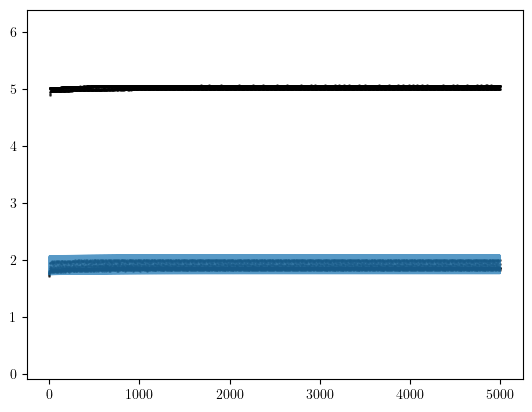

In [256]:
fig,axs = plt.subplots()
axs.plot(t,out12_ua.y[0]-a12.om*out12_ua.y[2],alpha=.75)
#axs.plot(t,out.y[1])
y = np.mod(phase12a - a12.om*phase12b,2*np.pi)
axs.scatter(tp12a,y,s=1,alpha=.5,color='k')
#axs.plot(t12,np.mod(solr12.y.T,2*np.pi),color='tab:red')
#axs.plot(t,out.y[3])
#axs.plot(t,np.mod(out.y[0],2*np.pi))
#axs.plot(t,np.mod(out.y[2],2*np.pi))
axs.set_ylim(-.1,2*np.pi+.1)
#axs.set_xlim(0,10)

### Multiple Initial Conditions

In [56]:
init_phases12b = np.linspace(0,2*np.pi,5,endpoint=False)

In [57]:
phase_iso = []
t = np.arange(0,1000,.01)
for i in range(len(init_phases12b)):
    init = [init_phases12b[i],.0,0,.0]
    solr12b = solve_ivp(_redu_c,[0,t12b[-1]],init,args=(eps12,del12),t_eval=t,**kw_sim)
    phase_iso.append(solr12b)

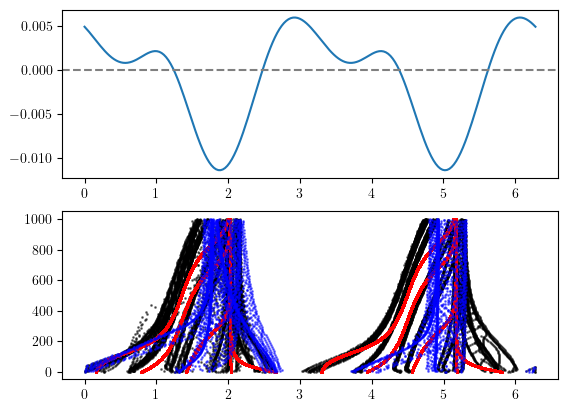

In [58]:
fig,axs = plt.subplots(2,1)
axs[0].plot(x_temp2,rhs)
axs[0].axhline(0,0,2*np.pi,ls='--',color='gray')

skipn = 1
for i in range(len(init_phases12)):
    y = np.mod(full_1[i][1] - a12.om*full_2[i][1],2*np.pi)
    axs[1].scatter(y[::skipn],full_1[i][0][::skipn],s=1,alpha=.5,color='k')
    axs[1].scatter(np.mod(redu_1[i].y[0]+np.pi/4,2*np.pi),redu_1[i].t,color='r',s=1,zorder=10)

skipn = 100
for i in range(len(init_phases12b)):
    y2 = np.mod(phase_iso[i].y[0] - a12.om*phase_iso[i].y[2],2*np.pi)
    axs[1].scatter(y2[::skipn],phase_iso[i].t[::skipn],color='b',s=1,zorder=20,alpha=.5)
    
#axs[0].set_xlim(0,2*np.pi)
#axs[1].set_xlim(0,2*np.pi)
plt.savefig('unave_blue_vs_full_black_vs_1d_red.png')

### Compare p_i functions between unaveraged and averaged

Need to use the same $\theta_i$ solution values when plugging into the $p_i$ functions to compare to $psi_i$.

In [169]:
tha_0 = out12_ua.y[0]; thb_0 = out12_ua.y[2]
eps_0 = eps21
psi_approx_a = eps_0*a12.system1.p['lam'][1](tha_0,thb_0) + eps_0**2*a12.system1.p['lam'][2](tha_0,thb_0) + eps_0**3*a12.system1.p['lam'][3](tha_0,thb_0)
psi_approx_b = eps_0*a12.system2.p['lam'][1](tha_0,thb_0) + eps_0**2*a12.system2.p['lam'][2](tha_0,thb_0) + eps_0**3*a12.system1.p['lam'][3](tha_0,thb_0)

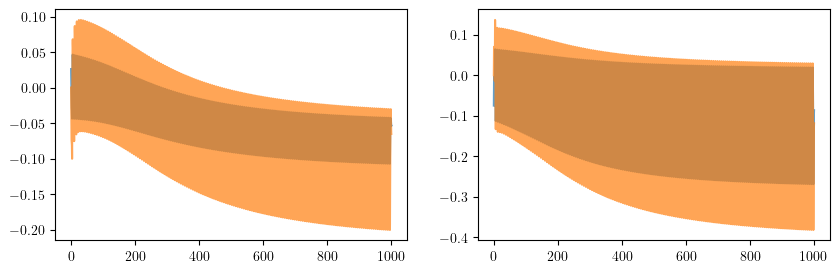

In [170]:
fig,axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(out12_ua.t,psi_approx_a,alpha=.7)
axs[0].plot(out12_ua.t,out12_ua.y[1],alpha=.7)

axs[1].plot(out12_ua.t,psi_approx_b,alpha=.7)
axs[1].plot(out12_ua.t,out12_ua.y[3],alpha=.7)

I mean... the fact that these solutions agree and that the directly integrated $p_i$ functions agree with the precomputed $p_i$ functions means that the issue lies with $\mathcal{H}$ calculations and not before.

## Averaged brute

### rhs

In [363]:
pd1 = a12.system1.pardict;pd2 = a12.system2.pardict
n = a12._n[1];m = a12._m[1]
x = a12.x;dx = a12.dx
s = x*m;ds = dx*m

K = pd1['K0'];kc = pd1['kc0']

def _redu_b(t,y,eps=0,del1=0):
    """full reduced model"""
    th0,ps0,th1,ps1 = y

    phi = th0 - a12.om*th1 ################### why do i need this pi/4??????
    
    x0 = x0_lam(phi + a12.om*s,ps0);y0 = y0_lam(phi + a12.om*s,ps0);z0 = z0_lam(phi + a12.om*s,ps0);v0 = v0_lam(phi + a12.om*s,ps0)
    x1 = x0_lam(s,ps1);y1 = y0_lam(s,ps1);z1 = z0_lam(s,ps1);v1 = v0_lam(s,ps1)

    F = (v0+v1)/2
    Ga = K0*F/(kc+K*F)
    
    dth0 = 1 + eps*(del1 + np.sum(z_lam0(phi + a12.om*s,ps0)[0,0]*Ga)*ds/(2*np.pi*m))
    dps0 = a12.system1.kappa_val*ps0 + eps*np.sum(i_lam0(phi + a12.om*s,ps0)[0,0]*Ga)*ds/(2*np.pi*m)

    dth1 = 1 + eps*np.sum(z_lam1(s,ps1)[0,0]*Ga)*ds/(2*np.pi*m)
    dps1 = a12.system2.kappa_val*ps1 + eps*np.sum(i_lam1(s,ps1)[0,0]*Ga)*ds/(2*np.pi*m)

    return np.array([dth0,dps0,dth1*m,dps1*m])

### Integrate

In [364]:
t = np.arange(0,5000,.01)
init = [th_init12,.0,0,.0]
out12_ub = solve_ivp(_redu_b,[t[0],t[-1]],init,args=(eps12,del12),t_eval=t,**kw_sim)

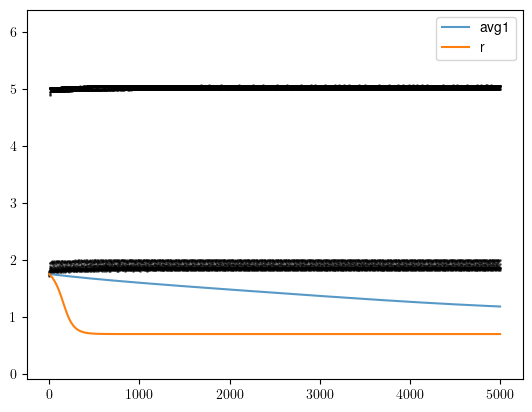

In [365]:
fig,axs = plt.subplots()
axs.plot(t,out12_ub.y[0]-a12.om*out12_ub.y[2],alpha=.75,label='avg1')
axs.plot(t,solr12.y[0],label='r')

y = np.mod(phase12a - a12.om*phase12b,2*np.pi)
axs.scatter(tp12a,y,s=1,alpha=.5,color='k')

axs.set_ylim(-.1,2*np.pi+.1)
axs.legend()

### Multiple Initial Conditions

In [342]:
phase_iso_avg = []
init_phases12bb = np.linspace(0,2*np.pi,10,endpoint=False)
t = np.arange(0,2000,.01)
for i in range(len(init_phases12bb)):
    init = [init_phases12bb[i],.0,0,.0]
    solr12c = solve_ivp(_redu_b,[0,t[-1]],init,args=(eps12,del12),t_eval=t,**kw_sim)
    phase_iso_avg.append(solr12c)

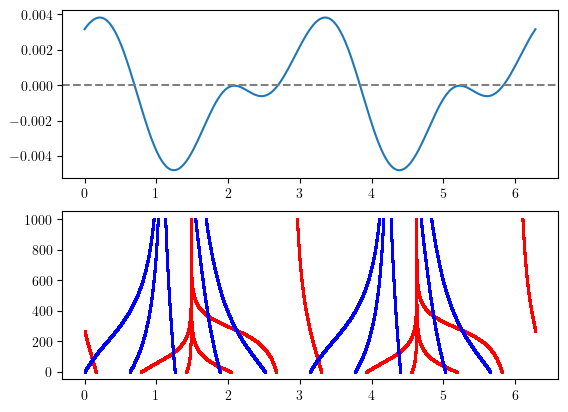

In [356]:
fig,axs = plt.subplots(2,1)
axs[0].plot(x_temp2,rhs)
axs[0].axhline(0,0,2*np.pi,ls='--',color='gray')

skipn = 1
for i in range(len(init_phases12)):
    # y = np.mod(full_1[i][1] - a12.om*full_2[i][1],2*np.pi)
    # axs[1].scatter(y[::skipn],full_1[i][0][::skipn],s=1,alpha=.5,color='k')
    axs[1].scatter(np.mod(redu_1[i].y[0]+np.pi/4,2*np.pi),redu_1[i].t,color='r',s=1,zorder=10)

# skipn = 100
# for i in range(len(init_phases12b)):
#     y2 = np.mod(phase_iso[i].y[0] - a12.om*phase_iso[i].y[2],2*np.pi)
    # axs[1].scatter(y2[::skipn],phase_iso[i].t[::skipn],color='r',s=1,zorder=20,alpha=.5)

for i in range(len(init_phases12bb)):
    y2 = np.mod((phase_iso_avg[i].y[0] - a12.om*phase_iso_avg[i].y[2]),2*np.pi)
    axs[1].scatter(y2[::skipn],phase_iso_avg[i].t[::skipn]/2,color='b',s=1,zorder=20,alpha=.5)


#axs[0].set_xlim(0,2*np.pi)
#axs[1].set_xlim(0,2*np.pi)
plt.savefig('ave_blue_vs_full_black_vs_1d_red.png')

## Check phase indexing

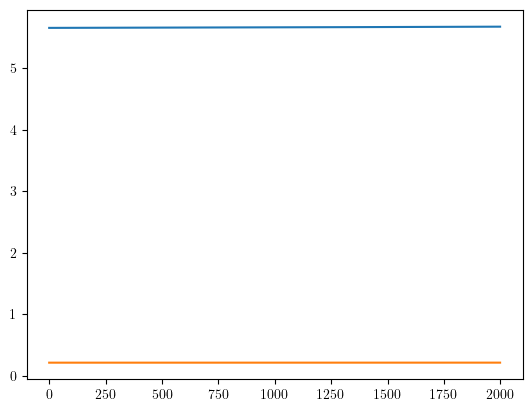

In [59]:
# check indexing for phase
sol_arr = solf12.y.T[:2000,:4]

fig,axs = plt.subplots()
axs.plot(sol_arr[:,0])

phase_value = []


for i in range(len(sol_arr)):
    d1 = np.linalg.norm(sol_arr[i,:]-a12.system1.lc['dat'],axis=1)
    phase_value.append(np.argmin(d1)/len(system1.lc['dat']))

axs.plot(phase_value)

# 2:1

In [60]:
a21 = nm.nmCoupling(system1,system2,
                    recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
                    #recompute_list=recompute_list,
                    _n=('om0',2),_m=('om1',1),
                    NP=700,
                    NH=700,
                    save_fig=True)

* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
* Loading H symbolic...
* Loading H symbolic...
h_data_gw0 ['p_data_gw0', 'p_data_gw1', 'h_data_gw0', 'h_data_gw1']
* Computing H gw0, order=0...
h_data_gw1 ['p_data_gw0', 'p_data_gw1', 'h_data_gw0', 'h_data_gw1']
* Computing H gw1, order=0...
h_data_gw0 ['p_data_gw0', 'p_data_gw1', 'h_data_gw0', 'h_data_gw1']
* Computing H gw0, order=1...
h_data_gw1 ['p_data_gw0', 'p_data_gw1', 'h_data_gw0', 'h_data_gw1']
* Computing H gw1, order=1...
h_data_gw0 ['p_data_gw0', 'p_data_gw1', 'h_data_gw0', 'h_data_gw1']
* Computing H gw0, order=2...
h_data_gw1 ['p_data_gw0', 'p_data_gw1', 'h_data_gw0', 'h_data_gw1']
* Computing H gw1, order=2...


In [61]:
eps21 = .05
del21 = 0.0
th_init21 = 0

First order starts losing accuracy around eps = 0.025 as eps increases (the reduced model reaches the same fixed point as the full model). Even at eps=0.02, the reduced and full models don't coincide in transients despite the long-term convergence.

Using order eps^2 at eps = 0.025 results in WORSE performance... So clearly if not p then there is something wrong with calculating h functions...

## Phase plane

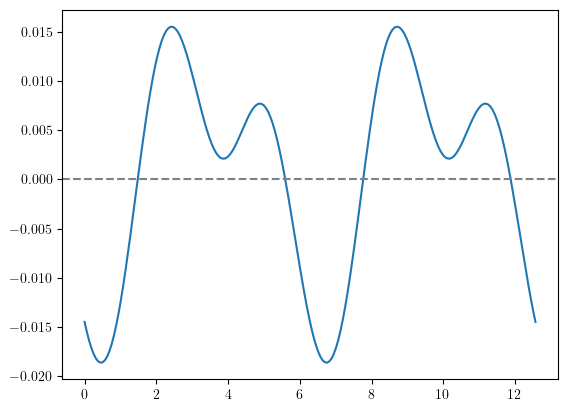

In [62]:
x_temp2 = np.linspace(0,4*np.pi,200)

rhs = _redu(0,x_temp2,a21,eps21,del21)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs)
axs.axhline(0,0,2*np.pi,ls='--',color='gray')

## Integrate

In [63]:
dt = .01;T=4000
t21 = np.arange(0,T,dt)
args21 = {'args':(a21,eps21,del21),'t_eval':t21,**kw_sim}

In [64]:
y0a = a21.system1.lc['dat'][int((th_init21/(2*np.pi))*a21.system1.TN),:]
y0b = a21.system2.lc['dat'][int((0/(2*np.pi))*a21.system2.TN),:]

y0 = np.array([y0a,y0b]).flatten()

solf21 = solve_ivp(_full,[0,t21[-1]],y0,**args21)

In [65]:
solr21 = solve_ivp(_redu,[0,t21[-1]],[th_init21],**args21)

(3799.9900000000002, 3999.9900000000002)

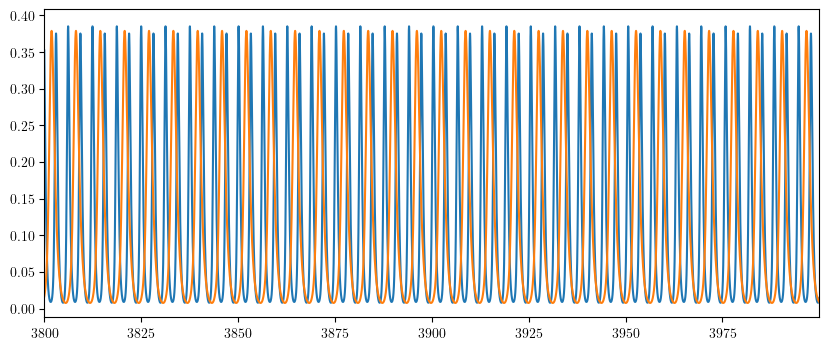

In [66]:
fig,axs = plt.subplots(figsize=(10,4))
axs.plot(solf21.t,solf21.y.T[:,0])
axs.plot(solf21.t,solf21.y.T[:,4])
#axs.set_xlim(sol_full.t[-1]-200,sol_full.t[-1])
axs.set_xlim(t21[-1]-200,t21[-1])

In [67]:
tp21a, phase21a = get_phase(t21,solf21.y.T[:,:4],skipn=50,system1=a21.system1)
tp21b, phase21b = get_phase(t21,solf21.y.T[:,4:],skipn=50,system1=a21.system2)

## Full vs phase

(0.0, 6.283185307179586)

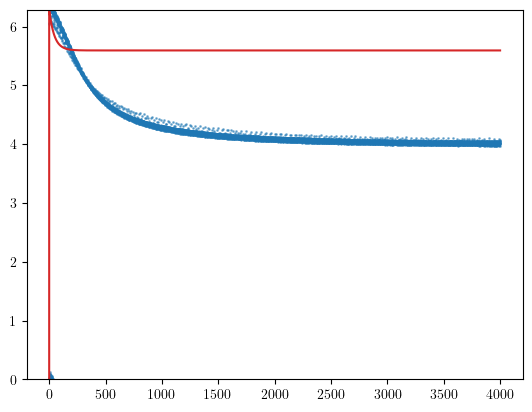

In [68]:
fig,axs = plt.subplots()
y = np.mod(phase21a - a21.om*phase21b,2*np.pi)
axs.scatter(tp21a,y,s=1,alpha=.5)
axs.plot(t21,np.mod(solr21.y.T,2*np.pi),color='tab:red')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)
axs.set_ylim(0,2*np.pi)

## Bifurcations

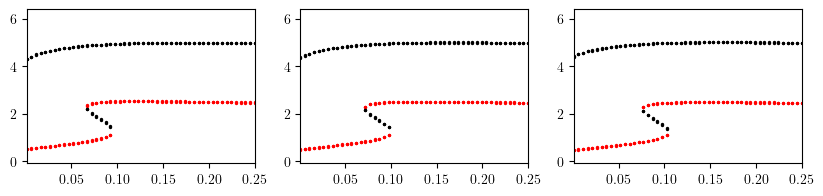

In [69]:
fig,axs=plt.subplots(1,3,figsize=(10,2))

del_list21 = np.linspace(-.002,.002,3)
eps_list21 = np.linspace(0.001,.25,50)

for k in range(len(del_list21)):
    add_diagram(axs[k],a21,del_list21[k],eps_list21)